# HVAE SISS

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import torch
import torchvision
import numpy as np
import nibabel as nib
from skimage import exposure

from sklearn.metrics import auc, roc_curve, average_precision_score, precision_recall_curve
from tqdm import tqdm, trange
from collections import defaultdict
from scipy.stats import multivariate_normal

import oodd
import oodd.models
import oodd.datasets
import oodd.losses
import oodd.evaluators
import oodd.utils
from oodd.layers.likelihoods import grayscale_log_continuous_mix_logistic


np.set_printoptions(suppress=True)
device = torch.device('cuda:1')

mood_brain_dir = '/data/mood/brain/brain_train'
mood_brain_mask_dir = '/data/mood/brain/toy_label/pixel'
mood_brain_toy_dir = '/data/mood/brain/toy'

mood_abdom_dir = '/data/mood/abdom/abdom_train'
mood_abdom_mask_dir = '/data/mood/abdom/toy_label/pixel'
mood_abdom_toy_dir = '/data/mood/abdom/toy'

DEFAULT_FONTSIZE = 13
sns.set_style('white')
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4),
})


ctx = sns.plotting_context('paper')

In [2]:
def make_strided_patches(img, patch_size=(28, 28), stride=(4, 4), tol=0.1, bg_tol=0.):
    """
    Returns a tuple of patches and coordinates given the a 2D slice of an image an optional 
    patch size and the stride length parameters.
    """
    # For our case of medical images, we discard images that are purely background
    if (img == 0).all():
        return None
    
    pipeline = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        oodd.datasets.transforms.PctileChauhan(0.05)
    ])

    def preprocess(arr, pipeline):
        arr = arr.astype('float32')
        return pipeline(arr)
    
    patches = []
    coords = []
    
    x_stride = stride[0]
    y_stride = stride[1]
    
    x_max = img.shape[0]
    y_max = img.shape[1]
    
    n_xstrides = (x_max - patch_size[0]) // x_stride
    n_ystrides = (y_max - patch_size[1]) // y_stride
    for x_stride_num in range(n_xstrides + 1):
        x_cur = x_stride_num * x_stride
        for y_stride_num in range(n_ystrides + 1):
            y_cur = y_stride_num * y_stride
            y2 = y_cur + patch_size[1]
            
            x2 = x_cur + patch_size[0]
            patch = img[x_cur : x2, y_cur: y2]
            if (patch <= bg_tol).sum() < int(patch_size[0] * patch_size[0] * tol):
                patches.append(preprocess(patch, pipeline))
                coords.append([x_cur, x2, y_cur, y2])
            
    if not patches:
        return None
    
    patches = torch.cat(patches).view(-1, 1, patch_size[0], patch_size[1])
    coords = torch.tensor(coords)
    return patches, coords

def image_generator(img_paths, tol=0):
    """Loads numpy arrays of images from disk"""
    for path in img_paths:
        img = nib.load(path)
        img_data = img.get_fdata()
        yield img_data, tol

### Loading Images From SISS Dataset

In [3]:
siss_nimg = nib.load('/home/derek/Training_T1_affmood/imgs/SISS02.nii.gz')
siss_arr = siss_nimg.get_fdata()

In [4]:
img = make_strided_patches(siss_arr[:, :, 128], stride=(7, 7))
img[0].shape

torch.Size([549, 1, 28, 28])

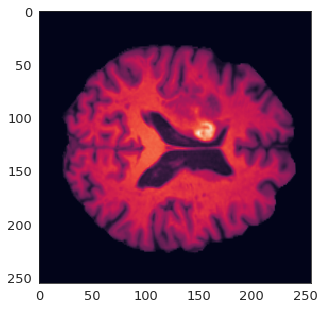

In [5]:
plt.imshow(siss_arr[:, :, 128])

In [6]:
p = '/home/derek/pred_siss2015/brain/'
imgs = os.listdir(p)
patch_llrs = {fn.split('_')[0]: np.load(os.path.join(p, fn))['scores'] for fn in imgs if 'results' in fn and 'axial' in fn}

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    1.,    1.,
           0.,    3.,    1.,    2.,    2.,    8.,    4.,    7.,    6.,
           5.,   10.,   11.,   15.,   20.,   29.,   46.,   42.,   72.,
          86.,   98.,  130.,  143.,  188.,  204.,  237.,  302.,  337.,
         436.,  438.,  535.,  644.,  780.,  880.,  988., 1271., 1451.,
        1694., 1860., 2241., 2440., 2883., 3254., 3728., 4124., 4705.,
        5334., 6048., 6584., 7217., 7789., 8358., 8770., 9129., 9180.,
        8890., 8911., 8565., 8478., 7926., 7443., 6969., 6380., 5713.,
        4860., 4148., 3334., 2850., 2286., 1880., 1553., 1132.,  781.,
         582.,  454.,  360.,  302.,  230.,  202.,  190.,  122.,   56.,
           5.]),
 array([3763.2578125 , 3802.32172852, 3841.38564453, 3880.44956055,
        3919.51347656, 3958.57739258, 3997.64130859, 4036.70522461,
        4075.76914063, 4114.83305664, 4153.89697266, 4192.96088867

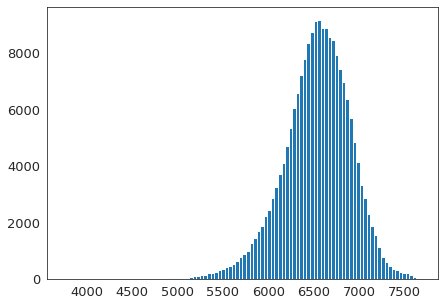

In [7]:
plt.hist(patch_llrs['SISS07'], bins=100)

In [8]:
p = '/home/derek/pred_siss2015/brain/'
imgs = os.listdir(p)
mean_llrs = []

for im in imgs:
    if 'unnormalized' in im and 'axial' in im:
        brain = nib.load(os.path.join(p, im))
        brain_arr = brain.get_fdata()
        mean_llr = brain_arr.sum() / np.count_nonzero(brain_arr)
        mean_llrs.append(mean_llr)

In [9]:
mean_llrs

[6531.718949818312,
 6304.095798492735,
 6314.388260320548,
 6271.033119633608,
 6332.10484290907,
 6297.273672438654,
 6340.028334296993,
 6313.070731431537,
 6381.049574531913,
 6284.659500536358,
 6303.263404176174,
 6478.215552405211,
 6255.569900020072,
 6330.2370074782975,
 6507.191453889704,
 6326.873857622304,
 6300.627373840266,
 6282.402483025453,
 6361.088558807623,
 6488.2902193317805,
 6577.942355610761,
 6536.958551429788,
 6250.523886557164,
 6321.0263940948635,
 6418.038012254065,
 6396.834332597816,
 6312.618540104676,
 6550.152339685044]

In [10]:
p = '/home/derek/pred_1_iw/brain/'
imgs = os.listdir(p)
mean_llrs = []

for im in imgs:
    if 'unnormalized' in im and 'axial' in im:
        brain = nib.load(os.path.join(p, im))
        brain_arr = brain.get_fdata()
        mean_llr = brain_arr.sum() / np.count_nonzero(brain_arr)
        mean_llrs.append(mean_llr)

In [11]:
mean_llrs

[6023.249013725792, 5980.346949984755, 5883.281637025031, 5831.515858634314]

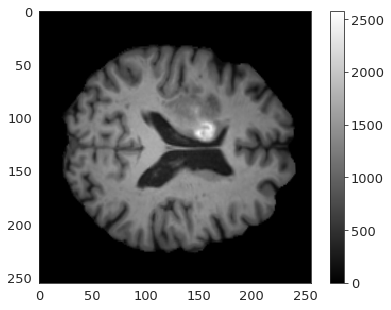

In [12]:
plt.imshow(siss_arr[:, :, 128], cmap='gray')
plt.colorbar()

In [13]:
siss_mask_nimg = nib.load('/home/derek/Training_T1_affmood/labels/SISS02_label.nii.gz')
siss_mask_arr = siss_mask_nimg.get_fdata()

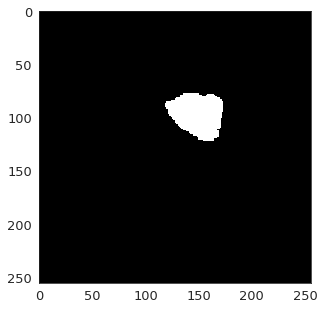

In [14]:
plt.imshow(siss_mask_arr[:, :, 128], cmap='gray')

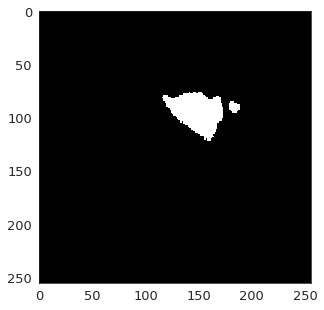

In [15]:
lesion_mask = siss_mask_arr[:, :, (siss_mask_arr == 1).any(axis=(0, 1))]
plt.imshow(lesion_mask[:, :, 50], cmap='gray')

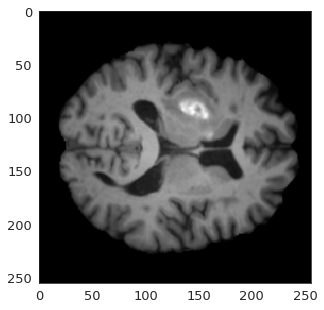

In [16]:
bool_lesion_slices = (siss_mask_arr == 1).any(axis=(0, 1))
slices_with_lesion = siss_arr[:, :, (siss_mask_arr == 1).any(axis=(0, 1))]
plt.imshow(slices_with_lesion[:, :, 50], cmap='gray')

(array([ 73874.,  38605.,  33339.,  33442.,  34993.,  35567.,  36827.,
         41657.,  47627.,  53751.,  58080.,  58762.,  60099.,  63305.,
         67046.,  69011.,  70619.,  75282.,  81856.,  90776.,  95778.,
        100693., 106077., 112879., 118970., 123378., 127282., 129319.,
        132223., 134096., 134051., 131951., 131108., 129152., 127917.,
        127507., 129123., 128523., 127213., 126316., 123470., 121923.,
        114507., 103930.,  92334.,  79751.,  68832.,  59864.,  53406.,
         47232.,  42424.,  36878.,  30059.,  22227.,  13013.,   6656.,
          3226.,   1775.,   1194.,    937.,    801.,    720.,    662.,
           615.,    577.,    583.,    498.,    505.,    440.,    439.,
           413.,    320.,    357.,    280.,    207.,    211.,    143.,
           130.,    120.,    129.,    100.,     79.,     71.,     53.,
            48.,     47.,     37.,     26.,     19.,     17.,     14.,
            10.,      7.,      1.,      5.,      2.,      2.,      2.,
      

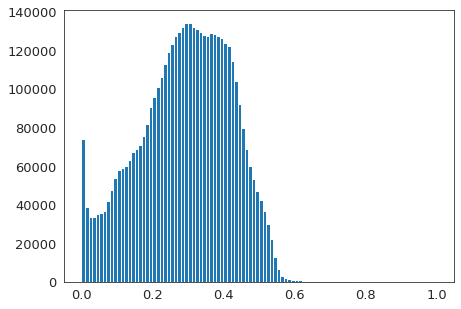

In [17]:
plt.hist(siss_arr.ravel()[siss_arr.ravel() != 0] / siss_arr.max(), bins=100)

In [18]:
sl = slices_with_lesion[:, :, 50]
sl /= sl.max()
eq_hist = exposure.equalize_adapthist(sl)

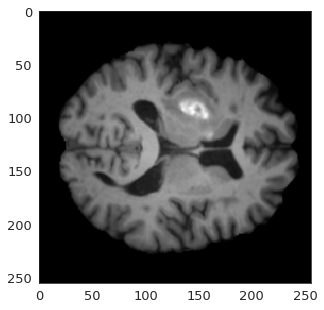

In [19]:
plt.imshow(sl, cmap='gray')

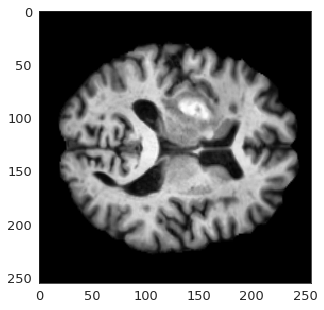

In [20]:
plt.imshow(eq_hist, cmap='gray')

(array([170., 132., 197., 214., 283., 309., 360., 375., 348., 334., 381.,
        312., 342., 323., 317., 306., 292., 290., 322., 299., 278., 331.,
        313., 324., 284., 321., 317., 341., 353., 346., 363., 360., 361.,
        348., 346., 411., 359., 372., 386., 410., 402., 398., 406., 447.,
        448., 422., 416., 457., 418., 473., 421., 447., 437., 441., 484.,
        439., 459., 451., 466., 451., 488., 461., 531., 501., 520., 571.,
        535., 565., 596., 617., 566., 625., 634., 573., 584., 627., 575.,
        597., 511., 448., 415., 376., 301., 259., 205., 164., 127., 111.,
        124.,  89.,  78.,  70.,  69.,  72.,  66.,  48.,  39.,  31.,  18.,
         13.]),
 array([0.0100246 , 0.01992435, 0.02982411, 0.03972386, 0.04962362,
        0.05952337, 0.06942312, 0.07932288, 0.08922263, 0.09912239,
        0.10902214, 0.11892189, 0.12882165, 0.1387214 , 0.14862116,
        0.15852091, 0.16842066, 0.17832042, 0.18822017, 0.19811993,
        0.20801968, 0.21791943, 0.22781919, 0.

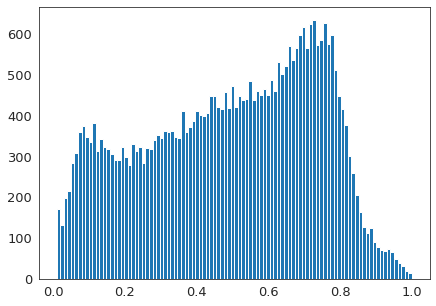

In [21]:
plt.hist(eq_hist.ravel()[(eq_hist > 0.01).ravel()], bins=100)

(array([ 257.,  147.,  109.,  120.,  143.,  122.,  173.,  173.,  236.,
         311.,  375.,  461.,  551.,  470.,  402.,  403.,  362.,  333.,
         355.,  397.,  365.,  392.,  442.,  466.,  472.,  477.,  567.,
         562.,  590.,  589.,  730.,  660.,  714.,  741.,  715.,  639.,
         691.,  640.,  641.,  640.,  645.,  624.,  610.,  726.,  737.,
         815.,  842.,  853.,  909., 1010., 1038., 1148., 1139., 1100.,
         994.,  833.,  804.,  675.,  463.,  393.,  309.,  233.,  175.,
          97.,   96.,  107.,  139.,   83.,   58.,   17.,   17.,   16.,
          12.,   10.,   12.,   13.,   15.,    9.,   11.,   11.,    7.,
          17.,   11.,   19.,    8.,   16.,    9.,    8.,    6.,   11.,
           6.,    4.,   10.,    2.,    5.,    3.,    7.,    4.,    2.,
           1.]),
 array([0.00000551, 0.01000545, 0.0200054 , 0.03000534, 0.04000529,
        0.05000523, 0.06000517, 0.07000512, 0.08000506, 0.09000501,
        0.10000495, 0.1100049 , 0.12000484, 0.13000479, 0.14000473

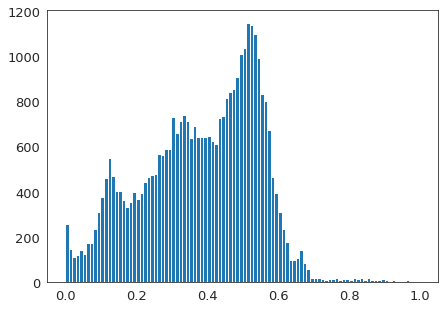

In [22]:
plt.hist(sl.ravel()[(sl != 0).ravel()], bins=100)

In [23]:
normal_patches, normal_coords = make_strided_patches(sl)
histeq_patches, histeq_coords = make_strided_patches(eq_hist, bg_tol=0.01)

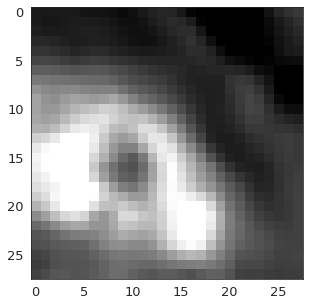

In [33]:
ind = 409
plt.imshow(normal_patches[ind].squeeze(), cmap='gray')

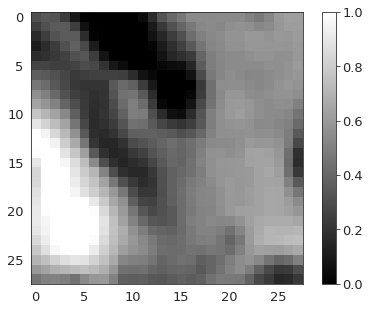

In [36]:
ind = 408
plt.imshow(histeq_patches[ind].squeeze(), cmap='gray')
plt.colorbar()

In [37]:
iw_samples_elbo = 1
iw_samples_Lk = 1
batch_size = 500
n_latents_skip = 2
n_eval_examples = float("inf")
criterion = oodd.losses.ELBO()

def get_decode_from_p(n_latents, k=0, semantic_k=True):
    """
    k semantic out
    0 True     [False, False, False]
    1 True     [True, False, False]
    2 True     [True, True, False]
    0 False    [True, True, True]
    1 False    [False, True, True]
    2 False    [False, False, True]
    """
    if semantic_k:
        return [True] * k + [False] * (n_latents - k)

    return [False] * (k + 1) + [True] * (n_latents - k - 1)

def get_lengths(dataloaders):
    return [len(loader) for name, loader in dataloaders.items()]

decode_from_p = get_decode_from_p(model_axial.n_latents, k=n_latents_skip)

scores = defaultdict(list)
elbos = defaultdict(list)
elbos_k = defaultdict(list)

dataset = torch.utils.data.TensorDataset(histeq_patches, histeq_coords)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
with torch.no_grad():
    n = 0
    for b, (x, _) in tqdm(enumerate(dataloader), total=int(np.ceil(len(dataset) / batch_size)), leave=True, position=0):
        x = x.to(device)

        n += x.shape[0]
        sample_elbos, sample_elbos_k = [], []

        # Regular ELBO
        for i in tqdm(range(iw_samples_elbo), leave=True):
            likelihood_data, stage_datas = model_axial(x, decode_from_p=False, use_mode=False)
            kl_divergences = [
                stage_data.loss.kl_elementwise
                for stage_data in stage_datas
                if stage_data.loss.kl_elementwise is not None
            ]
            loss, elbo, likelihood, kl_divergences = criterion(
                likelihood_data.likelihood,
                kl_divergences,
                samples=1,
                free_nats=0,
                beta=1,
                sample_reduction=None,
                batch_reduction=None,
            )
            sample_elbos.append(elbo.detach())

        # L>k bound
        for i in tqdm(range(iw_samples_Lk), leave=True):
            likelihood_data_k, stage_datas_k = model_axial(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
            kl_divergences_k = [
                stage_data.loss.kl_elementwise
                for stage_data in stage_datas_k
                if stage_data.loss.kl_elementwise is not None
            ]
            loss_k, elbo_k, likelihood_k, kl_divergences_k = criterion(
                likelihood_data_k.likelihood,
                kl_divergences_k,
                samples=1,
                free_nats=0,
                beta=1,
                sample_reduction=None,
                batch_reduction=None,
            )
            sample_elbos_k.append(elbo_k.detach())

        sample_elbos = torch.stack(sample_elbos, axis=0)
        sample_elbos_k = torch.stack(sample_elbos_k, axis=0)

        sample_elbo = oodd.utils.log_sum_exp(sample_elbos, axis=0)
        sample_elbo_k = oodd.utils.log_sum_exp(sample_elbos_k, axis=0)

        score = sample_elbo - sample_elbo_k

        scores['healthy'].extend(score.tolist())
        elbos['healthy'].extend(sample_elbo.tolist())
        elbos_k['healthy'].extend(sample_elbo_k.tolist())

NameError: name 'model_axial' is not defined

In [ ]:
plt.hist(scores['healthy'], bins=50)

In [ ]:
plt.hist(scores['healthy'], bins=50)

In [ ]:
plt.imshow(arr[:, :, bool_lesion_slices][:, :, 50])

In [ ]:
nimg = nib.load('/home/derek/pred_siss2015/brain/SISS12.nii.gz')
arr = nimg.get_fdata()

In [ ]:
plt.imshow(arr[:, :, bool_lesion_slices][:, :, 40], cmap='gray')
plt.colorbar()